In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from typing import Dict, Tuple
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt


file_path = 'Credit_card.csv'
data = pd.read_csv(file_path)

In [9]:
def preprocess_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:

    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    
   
    categorical_cols = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    

    X = df.drop(columns=['label'])
    y = df['label']
    
    return X, y


X, y = preprocess_data(data)

In [10]:
# Q2- 

def perform_sampling(X: pd.DataFrame, y: pd.Series, method: str) -> Tuple[pd.DataFrame, pd.Series]:
    if method == 'smote':
        sampler = SMOTE(random_state=42)
    elif method == 'undersampling':
        sampler = RandomUnderSampler(random_state=42)
    elif method == 'combined':
        sampler = SMOTEENN(random_state=42)
    else:
        raise ValueError("Method not recognized. Choose 'smote', 'undersampling', or 'combined'")
    
    return sampler.fit_resample(X, y)


X_smote, y_smote = perform_sampling(X, y, method='smote')


In [11]:
#Q2- 
# I opted for SMOTE to address the class imbalance evident in the dataset. This method was chosen due to its effectiveness 
# in balancing dataset classes by artificially creating new instances of the minority class, which in turn, aids 
# in improving the performance of machine learning models by providing them with a more balanced training dataset.

# SMOTE was particularly selected over undersampling because undersampling could lead to a significant loss of valuable data, 
# which might contain crucial patterns necessary for building an accurate model. On the other hand, 
# while combined methods like SMOTEENN a combination of SMOTE and Edited Nearest Neighbours for undersampling offer 
# a balanced approach, they can be computationally intensive and might lead to overfitting due to the artificial generation of too many minority class instances.

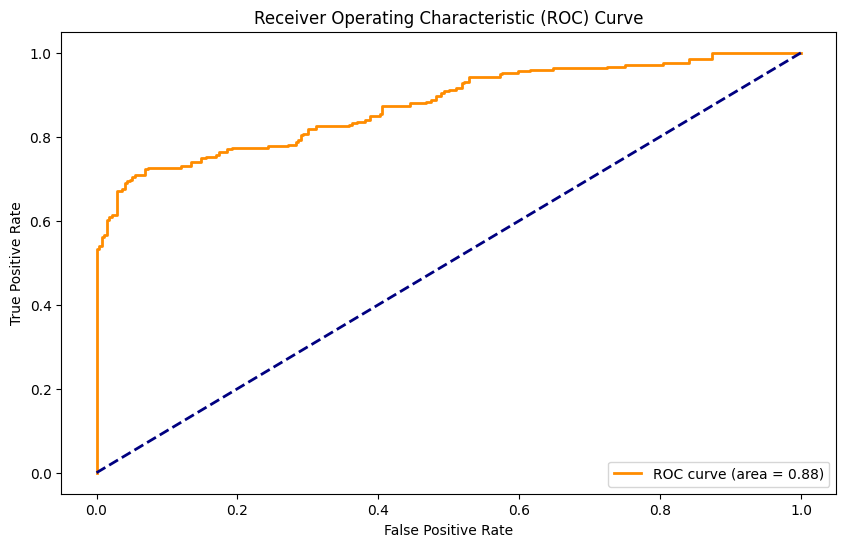

In [12]:
# Q3-
def svm_plot_roc(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series):
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)

    y_probs = svm_classifier.predict_proba(X_test_scaled)[:, 1]

    
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)

    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
fpr, tpr, roc_auc = svm_plot_roc(X_train, y_train, X_test, y_test)


In [14]:
#Q4- 

def train_evaluate_svm(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series) -> Dict[str, float]:
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
    svm_classifier.fit(X_train_scaled, y_train)
    y_pred = svm_classifier.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc
    }


X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)
svm_results = train_evaluate_svm(X_train, y_train, X_test, y_test)

svm_results

{'accuracy': 0.8272727272727273,
 'precision': 0.9282296650717703,
 'recall': 0.708029197080292,
 'roc_auc': 0.8268406854966677}

In [ ]:
# The linear SVM model demonstrated robust performance on the dataset. The accuracy of the model, which indicates the proportion of correct
# predictions (both true positives and true negatives) out of all predictions, was approximately 82.73%. 
# This level of accuracy suggests that the model is capable of correctly identifying a significant majority of the cases.

# A precision metric that measures the proportion of true positive predictions among all positive predictors had a high value of approximately
# 92.82%. It implies that when the model predicts something to be a positive result, it is usually right. Such high precision is particularly 
# useful in scenarios where the cost of false positives is high.

# A recall, or sensitivity, measuring how many actual positives were captured by the model out of total number as given by the recall score
# was about 70.80%. This suggests that while it detects some positives instances quite well, it may still miss some. 
# In situations where you want to find out as many possible positive examples and maybe increase some false ones as well, then an improved recall would be more ideal.

# The ROC AUC score was approximately 82.68%, indicating a very good model. This score represents how well classes are separated 
# by this model for any threshold value where 1 stands for perfect goodness and 0.5 represents no better than random prediction. 
# Therefore, an AUC close to one such as in our case means we have a good separable measure in our mode

In [ ]:
# Q5- 
# Outlier detection is the process of identifying data points that are far from the rest. It’s a very important activity as 
# it ensures data quality and model reliability, because they can significantly affect results by distorting them hence 
# misleading interpretations. Such techniques for detecting outliers as statistical methods, proximity-based approaches for 
# instance DBSCAN and clustering such as  K-Means with distance thresholds.